# AGNNES

TBD

## Init

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [8]:
import AGNNES_params as RP
import AGNNES_functions as RF
import AGNNES_MCMC as RS
import AGNNES_model as RM

In [ ]:
#Reading the output file and getting the MCMC final chain
reader = emcee.backends.HDFBackend("sampler-M87.h5", read_only=True)
flatchain = reader.get_chain(flat=True)

### Autocorrelation time

The autocorrelation time is a convergence criterion for the MCMC. We followed [Goodman & Weare 2010](https://msp.org/camcos/2010/5-1/p04.xhtml) criterion, which the autocorrelation time $\tau$ might be related to the MCMC's number of steps $N$ by $N/50 \gtrsim \tau$.

There is an associated $\tau$ for each of the fitting variables.

In [ ]:
#tau value
tau=reader.get_autocorr_time(tol=0)
#tau*50 should be smaller than the number of steps
print('Number of steps: '+str(RP.n1+RP.n2)+'\n'+'50*tau: '+str(tau*50))

### Plotting

Using AGNNES functions we will make some plots. The same as figures in [Almeida, Duarte & Nemmen 2021](https://doi.org/10.1093/mnras/stab3353).

In [ ]:
import importlib
importlib.reload(RP)
#data files
data_file='Library/SED-'+RP.filename+'.txt'
limits_file='Library/SED-'+RP.filename+'-limits.txt'

In [ ]:
#Do not change this cell!!!

#Reading the parameters file
observations = pd.read_csv(data_file, sep=",")
limits = pd.read_csv(limits_file, sep=",")

#Data points
xdata=observations['nu']
ydata=observations['nulnu']
#We are using symmetric errors (need to be improved)
yerror=(observations['unulnu']-observations['lnulnu'])/2.
yerror_up, yerror_low=observations['unulnu']-observations['nulnu'],observations['nulnu']-observations['lnulnu']
#Our code need the errorbars, for observations without errors we defined this minimal error
yerror[yerror<0.05]=0.05 

#upper limits (no need of errorbars)
xlims=limits['nu']
ylims=limits['lnulnu']


#mass
real_mass=np.log10(RP.real_mass/1.e6)
#real_mass=(RP.real_mass/1.e6)

#priors
prior=RS.prior
prior_jet=RS.prior_jet

#number of free parameters for adaf/jet
ndim_jet=4
ndim_adaf=3

#Normalizations
X_delta_min,X_delta_max,X_ar_min,X_ar_max,X_mass_max,X_mass_min,X_s_max,X_s_min, Y_max, Y_min = RF.X_delta_min,RF.X_delta_max,RF.X_ar_min,RF.X_ar_max,RF.X_mass_max,RF.X_mass_min, RF.X_s_max,RF.X_s_min, RF.Y_max, RF.Y_min
X_ar_jet_min,X_ar_jet_max,X_p_min,X_p_max,X_mass_jet_max,X_mass_jet_min,X_epse_max,X_epse_min,X_epsb_max,X_epsb_min, Y_jet_max, Y_jet_min = RF.X_ar_jet_min,RF.X_ar_jet_max,RF.X_p_min,RF.X_p_max,RF.X_mass_jet_max,RF.X_mass_jet_min, RF.X_epse_max,RF.X_epse_min, RF.X_epsb_max,RF.X_epsb_min, RF.Y_jet_max, RF.Y_jet_min


#BH mass
mass_n=(real_mass-X_mass_min)/(X_mass_max-X_mass_min)
mass_jet=(10**real_mass-X_mass_jet_min)/(X_mass_jet_max-X_mass_jet_min)

In [ ]:
filename='M87' #name of your object
save=False #if you wish to save the figures (True or False)

After you imported all parameters from `AGNNES_params.py`, let's work with the data sampler.

In [ ]:
#The size of the sampler depends on your hardware specs, if you take all the points your RAM could be not enough
sampler=flatchain[-3000000:]
#ndim is the number of free parameters. 3 for ADAF, 4 for jet or 7 for adaf + jet
ndim=len(tau)

### The chain

The following snippet of code will let you visualize the evolution of your chain for each parameter.

In [ ]:
figChain = plt.figure()
figChain.set_size_inches((15,5))
chain=sampler
if(ndim==3):
    lab= ['delta', 'mdot', 's']
if(ndim==4):
    lab=['mdot', 'p', 'epse', 'epsb']
if(ndim==7):
    lab=[r'$\delta$', r'$\dot{M}$', 's', r'$\dot{M}$_j', 'p', r'$\epsilon_e$', r'$\epsilon_B$']

for i in range(len(chain.T)):
    plt.subplot(len(chain.T),1,i+1)
    plt.plot(chain.T[i], 'k')
    plt.ylabel(lab[i])

#saving figure
if (save==True):
    plt.savefig('Results/'+filename+'-chain.png')
    


### Distribution plots

From the `sampler` we can  plot our distribution as an histogram. We will consider the uncertaities as the region of $1\sigma$ from the distribution integral.

In [ ]:
#extracting the values from MCMC adjust
samples = sampler[:,:].reshape((-1, ndim))
#We are taking values for the following percentiles:16%, 50% (average value), 84%
#16% and 84% are related to 1 sigma uncertainties
if(ndim==3):
    delta_mcmc, mdot_mcmc, s_mcmc = map(lambda v: (v[1], v[1]-v[0], v[2]-v[1]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
if(ndim==4):
    mdot_mcmc, p_mcmc, epse_mcmc, epsb_mcmc = map(lambda v: (v[1], v[1]-v[0], v[2]-v[1]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
if(ndim==7):
    delta_mcmc, mdot_mcmc, s_mcmc, mdotj_mcmc, p_mcmc, epse_mcmc, epsb_mcmc = map(lambda v: (v[1], v[1]-v[0], v[2]-v[1]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))

In [ ]:
#Figure 2: Distibution in triangle plot
if(ndim==3):
    figTriangle = corner.corner(samples, bins=100, labels=[ '$\delta$', '$\log_{10} \dot{m}$', "$s$"], truths=[delta_mcmc[0], mdot_mcmc[0], s_mcmc[0]], fontsize=16.)
if(ndim==4):
    figTriangle = corner.corner(samples, labels=[ '$\log_{10} \dot{m}$', "$p$", '$\epsilon_E$', '$\epsilon_B$'], truths=[mdot_mcmc[0], p_mcmc[0], epse_mcmc[0], epsb_mcmc[0]])
if(ndim==7):
    figTriangle = corner.corner(samples, labels=[ '$\delta$', '$\log_{10} \dot{m}$', "$s$", '$\log_{10} \dot{m}$', "$p$", '$\log_{10} \epsilon_E$', '$\log_{10} \epsilon_B$'], truths=[delta_mcmc[0], mdot_mcmc[0], s_mcmc[0], mdotj_mcmc[0], p_mcmc[0], epse_mcmc[0], epsb_mcmc[0]])
figTriangle.set_size_inches((15,15))
#saving figure
if (save==True):
    plt.savefig('Results/'+filename+'-fit.png')

### SED plot

Now the main plot: the SED. There are differences in the plot code, depending on the value of `ndim`. All the code here is to plot everything, do not worry.

In [ ]:
#Figure 3: The fitting
fig, ax = plt.subplots()
fig.set_size_inches((15,10))
if(ndim==3):
    #Plotting "Uncertainties"
    for delta, mdot,s in samples[np.random.randint(len(samples), size=100)]:
        delta=RF.normalizer(delta, X_delta_min, X_delta_max)
        mdot=RF.normalizer(mdot, X_ar_min, X_ar_max)
        s=RF.normalizer(s, X_s_min, X_s_max)
        plt.plot(np.array(range(99))/99.*(20.88-9.12)+9.12,RM.adaf.predict(np.array([[mass_n, delta, abs(mdot), abs(s)]]))[0]*Y_min + Y_max, color="k", alpha=0.05)

    #Translating NN values to physical values
    delta_best=RF.normalizer(delta_mcmc[0], X_delta_min, X_delta_max)
    mdot_best=RF.normalizer(mdot_mcmc[0], X_ar_min, X_ar_max)
    s_best=RF.normalizer(s_mcmc[0], X_s_min, X_s_max)
    #Plotting data
    plt.errorbar(xdata,ydata, yerr=(yerror),linestyle='none',fmt='ok',ecolor='gray')
    #Plotting upperlimits
    plt.plot(xlims, ylims, 'o', marker=r'$\downarrow$', color='black', markersize=18.)
    #plt.plot(xlim, ylim, color='red', marker='^')
    #Plotting best fit
    plt.plot(RF.nu_off[:-1],RM.adaf.predict(np.array([[mass_n, delta_best, mdot_best, s_best]]))[0]*Y_min + Y_max, '--b', label='Best fit', linewidth=2.5)
    plt.legend()

    #Printing physical values with Uncertainties
    #mdot need special treatment because we modelled log_10(mdot)
    print(r'delta = '+str(delta_mcmc[0])+' + '+str(delta_mcmc[2])+' - '+str(delta_mcmc[1]))
    mdot_mcmc2=[mdot_mcmc[0],mdot_mcmc[0]-mdot_mcmc[1],mdot_mcmc[0]+mdot_mcmc[2]]
    mdot_real=np.array([mdot_mcmc2[0],abs(mdot_mcmc2[0]-mdot_mcmc2[1]),abs(mdot_mcmc2[0]-mdot_mcmc2[2])])
    print(r'log10(mdot) = '+str(mdot_real[0])+' + '+str(mdot_real[2])+' - '+str(mdot_real[1]))
    mdot_exp=np.array([1, np.log(10.)*mdot_real[1],np.log(10.)*mdot_real[2]])*10.**mdot_real[0]
    print(r'mdot = '+str(mdot_exp[0])+' + '+str(mdot_exp[2])+' - '+str(mdot_exp[1]))
    print(r's = '+str(s_mcmc[0])+' + '+str(s_mcmc[2])+' - '+str(s_mcmc[1]))

    adaf_sed=RM.adaf.predict(np.array([[mass_n, delta_best, mdot_best, s_best]]))[0]*Y_min + Y_max
    total_interp=RF.interpolation(adaf_sed, x_sed=RF.nu_off[:-1])
    chi2_final=sum((total_interp(xdata)-ydata)**2/(yerror**2))/len(xdata-7)

if(ndim==4):
    #Plotting "Uncertainties"
    for mdot,p,epse, epsb in samples[np.random.randint(len(samples), size=100)]:
        mdot=RF.normalizer(mdot, X_ar_jet_min, X_ar_jet_max)
        p=RF.normalizer(p, X_p_min, X_p_max)
        epse=RF.normalizer(epse, X_epse_min, X_epse_max)
        epsb=RF.normalizer(epsb, X_epsb_min, X_epsb_max)
        plt.plot(np.linspace(8.2, 21.1, 130),RM.jet.predict(np.array([[mass_jet, abs(mdot), abs(p), abs(epse), abs(epsb)]]))[0]*(Y_jet_max - Y_jet_min) + Y_jet_min, color="k", alpha=0.05)

    #Translating NN values to physical values
    p_best=RF.normalizer(p_mcmc[0], X_p_min, X_p_max)
    mdot_best=RF.normalizer(mdot_mcmc[0], X_ar_jet_min, X_ar_jet_max)
    epse_best=RF.normalizer(epse_mcmc[0], X_epse_min, X_epse_max)
    epsb_best=RF.normalizer(epsb_mcmc[0], X_epsb_min, X_epsb_max)
    #Plotting data
    plt.errorbar(xdata,ydata, yerror,linestyle='none',fmt='ok',ecolor='gray')
    #Plotting upperlimits
    plt.plot(xlims, ylims, 'o', marker=r'$\downarrow$', color='black', markersize=18.)
    #plt.arrow(xlim, ylim, dx=xlim*0, dy=xlim*0+1., color='green')
    #Plotting best fit
    plt.plot(RF.nu_jet,RM.jet.predict(np.array([[mass_jet, mdot_best, p_best, epse_best, epsb_best]]))[0]*(Y_jet_max - Y_jet_min) + Y_jet_min, '--b', label='Best fit', linewidth=2.5)
    plt.legend()

    #Printing physical values with Uncertainties
    #mdot need special treatment because we modelled log_10(mdot)
    mdot_mcmc2=[mdot_mcmc[0],mdot_mcmc[0]-mdot_mcmc[1],mdot_mcmc[0]+mdot_mcmc[2]]
    mdot_real=np.array([mdot_mcmc2[0],abs(mdot_mcmc2[0]-mdot_mcmc2[1]),abs(mdot_mcmc2[0]-mdot_mcmc2[2])])
    print(r'log10(mdot) = '+str(mdot_real[0])+' + '+str(mdot_real[2])+' - '+str(mdot_real[1]))
    mdot_exp=np.array([1, np.log(10.)*mdot_real[1],np.log(10.)*mdot_real[2]])*10.**mdot_real[0]
    print(r'mdot = '+str(mdot_exp[0])+' + '+str(mdot_exp[2])+' - '+str(mdot_exp[1]))
    print(r'p = '+str(p_mcmc[0])+' + '+str(p_mcmc[2])+' - '+str(p_mcmc[1]))
    print(r'$\epsilon_E$ = '+str(epse_mcmc[0])+' + '+str(epse_mcmc[2])+' - '+str(epse_mcmc[1]))
    print(r'$\epsilon_B$ = '+str(epsb_mcmc[0])+' + '+str(epsb_mcmc[2])+' - '+str(epsb_mcmc[1]))

    #auxiliar value for print mdot in the main plot
    aux_mdot=int(np.log10(mdot_exp[0])-1.)
    
if(ndim==7):
    #Plotting "Uncertainties"
    for delta, mdot,s, mdotj,p,epse, epsb in samples[np.random.randint(len(samples), size=100)]:
        delta=RF.normalizer(delta, X_delta_min, X_delta_max)
        mdot=RF.normalizer(mdot, X_ar_min, X_ar_max)
        s=RF.normalizer(s, X_s_min, X_s_max)
        mdotj=RF.normalizer(mdotj, X_ar_jet_min, X_ar_jet_max)
        p=RF.normalizer(p, X_p_min, X_p_max)
        epse=RF.normalizer(epse, X_epse_min, X_epse_max)
        epsb=RF.normalizer(epsb, X_epsb_min, X_epsb_max)
        jet_md=RM.jet.predict(np.array([[mass_jet, abs(mdotj), abs(p), abs(epse), abs(epsb)]]))[0]*(RF.Y_jet_max - RF.Y_jet_min) + RF.Y_jet_min
        jet_spec=RF.interpolation(jet_md, x_sed=RF.nu_jet)
        sum_spec=np.log10(10**(RM.adaf.predict(np.array([[mass_n, delta, abs(mdot), abs(s)]]))[0]*Y_min + Y_max-30.) + 10**(jet_spec(RF.nu_off[:-1])-30.))
        #plt.plot(RF.nu_off[:-1],np.log10(sum_spec), color="k", alpha=0.05)
        plt.plot(np.array(range(99))/99.*(20.88-9.12)+9.12,(sum_spec+30.), color="k", alpha=0.05)
        #plt.plot(np.array(range(99))/99.*(20.88-9.12)+9.12,RM.adaf.predict(np.array([[mass_n, delta, abs(mdot), abs(s)]]))[0]*(Y_max - Y_min) + Y_min, color="k", alpha=0.05)
    #print(sum_spec)

    #Translating NN values to physical values
    delta_best=RF.normalizer(delta_mcmc[0], X_delta_min, X_delta_max)
    mdot_best=RF.normalizer(mdot_mcmc[0], X_ar_min, X_ar_max)
    s_best=RF.normalizer(s_mcmc[0], X_s_min, X_s_max)
    p_best=RF.normalizer(p_mcmc[0], X_p_min, X_p_max)
    mdotj_best=RF.normalizer(mdotj_mcmc[0], X_ar_jet_min, X_ar_jet_max)
    epse_best=RF.normalizer(epse_mcmc[0], X_epse_min, X_epse_max)
    epsb_best=RF.normalizer(epsb_mcmc[0], X_epsb_min, X_epsb_max)
    #Plotting data
    plt.errorbar(xdata,ydata, yerror#yerr=(yerror_low, yerror_up)
                 ,linestyle='none',fmt='ok',ecolor='gray')
    #Plotting upperlimits
    plt.plot(xlims, ylims, 'o', marker=r'$\downarrow$', color='black', markersize=18.)

    #Plotting best fit
    #seds
    jet_sed=RM.jet.predict(np.array([[mass_jet, abs(mdotj_best), abs(p_best), abs(epse_best), abs(epsb_best)]]))[0]*(Y_jet_max - Y_jet_min) + Y_jet_min
    adaf_sed=RM.adaf.predict(np.array([[mass_n, delta_best, mdot_best, s_best]]))[0]*Y_min + Y_max
    #interpolating jet sed in order to sum jet+adaf seds
    jet_interp=RF.interpolation(jet_sed, x_sed=RF.nu_jet)
    total_sed= np.log10(10**(adaf_sed-30.) + 10**(jet_interp(RF.nu_off[:-1])-30.))+30.
    #plots
    plt.fill_between(RF.nu_off[:-1], total_sed-0.05, total_sed+0.05, color='grey', alpha=0.5)
    plt.plot(RF.nu_jet,jet_sed, '--b', linewidth=2.,label='Jet')
    plt.plot(RF.nu_off[:-1],adaf_sed, '-.r', linewidth=2., label='ADAF')
    plt.plot(RF.nu_off[:-1],total_sed, '-k', linewidth=3., label='Total')
    plt.legend(fontsize=18.)
    plt.xlim(RF.nu_off[0]-0.5,RF.nu_off[-1]+0.5)
    plt.ylim(np.min([np.min(ydata)-0.5,np.min(ylims)-1,39.]), np.max([np.max(ydata),np.max(ylims)])+1)
    plt.ylim(36,43)
    plt.xlim(8,20)
    #plt.ylim(41.1,41.7)
    #plt.legend()

    #Printing physical values with Uncertainties
    print(r'delta = '+str(delta_mcmc[0])+' + '+str(delta_mcmc[2])+' - '+str(delta_mcmc[1]))
    mdot_mcmc2=[mdot_mcmc[0],mdot_mcmc[0]-mdot_mcmc[1],mdot_mcmc[0]+mdot_mcmc[2]]
    mdot_real=np.array([mdot_mcmc2[0],abs(mdot_mcmc2[0]-mdot_mcmc2[1]),abs(mdot_mcmc2[0]-mdot_mcmc2[2])])
    print(r'log10(mdot) = '+str(mdot_real[0])+' + '+str(mdot_real[2])+' - '+str(mdot_real[1]))
    mdot_exp=np.array([1, np.log(10.)*mdot_real[1],np.log(10.)*mdot_real[2]])*10.**mdot_real[0]
    print(r'mdot = '+str(mdot_exp[0])+' + '+str(mdot_exp[2])+' - '+str(mdot_exp[1]))
    print(r's = '+str(s_mcmc[0])+' + '+str(s_mcmc[2])+' - '+str(s_mcmc[1]))
    #mdot need special treatment because we modelled log_10(mdot)
    mdotj_mcmc2=[mdotj_mcmc[0],mdotj_mcmc[0]-mdotj_mcmc[1],mdotj_mcmc[0]+mdotj_mcmc[2]]
    mdotj_real=np.array([mdotj_mcmc2[0],abs(mdotj_mcmc2[0]-mdotj_mcmc2[1]),abs(mdotj_mcmc2[0]-mdotj_mcmc2[2])])
    print(r'log10(mdot) = '+str(mdotj_real[0])+' + '+str(mdotj_real[2])+' - '+str(mdotj_real[1]))
    mdotj_exp=np.array([1, np.log(10.)*mdotj_real[1],np.log(10.)*mdotj_real[2]])*10.**mdotj_real[0]
    print(r'mdotj = '+str(mdotj_exp[0])+' + '+str(mdotj_exp[2])+' - '+str(mdotj_exp[1]))
    print(r'p = '+str(p_mcmc[0])+' + '+str(p_mcmc[2])+' - '+str(p_mcmc[1]))
    epse_mcmc2=[epse_mcmc[0],epse_mcmc[0]-epse_mcmc[1],epse_mcmc[0]+epse_mcmc[2]]
    epse_real=np.array([epse_mcmc2[0],abs(epse_mcmc2[0]-epse_mcmc2[1]),abs(epse_mcmc2[0]-epse_mcmc2[2])])
    print(r'log10($\epsilon_E$) = '+str(epse_real[0])+' + '+str(epse_real[2])+' - '+str(epse_real[1]))
    epse_exp=np.array([1, np.log(10.)*epse_real[1],np.log(10.)*epse_real[2]])*10.**epse_real[0]
    print(r'$\epsilon_E$ = '+str(epse_exp[0])+' + '+str(epse_exp[2])+' - '+str(epse_exp[1]))
    epsb_mcmc2=[epsb_mcmc[0],epsb_mcmc[0]-epsb_mcmc[1],epsb_mcmc[0]+epsb_mcmc[2]]
    epsb_real=np.array([epsb_mcmc2[0],abs(epsb_mcmc2[0]-epsb_mcmc2[1]),abs(epsb_mcmc2[0]-epsb_mcmc2[2])])
    print(r'log10($\epsilon_B$) = '+str(epsb_real[0])+' + '+str(epsb_real[2])+' - '+str(epsb_real[1]))
    epsb_exp=np.array([1, np.log(10.)*epsb_real[1],np.log(10.)*epsb_real[2]])*10.**epsb_real[0]
    print(r'$\epsilon_B$ = '+str(epsb_exp[0])+' + '+str(epsb_exp[2])+' - '+str(epsb_exp[1]))
    
    #auxiliar value for print mdot in the main plot
    aux_mdot=int(np.log10(mdot_exp[0])-1.)
    aux_mdotj=int(np.log10(mdotj_exp[0])-1.)
    
    #calculating chi-square
    total_interp=RF.interpolation(total_sed, x_sed=RF.nu_off[:-1])
    chi2_final=sum((total_interp(xdata)-ydata)**2/(yerror**2))/len(xdata-7)
    print(r'$\chi^2 = $'+str(chi2_final))

#Plot details
plt.title(filename, fontsize=28)#str(title)+r' delta = '+str(round(delta_mcmc[0],2))+' + '+str(round(delta_mcmc[2],2))+' - '+str(round(delta_mcmc[1],2))+r' mdot = '+str('{:.2e}'.format(mdot_exp[0]))+' + '+str('{:.2e}'.format(mdot_exp[2]))+' - '+str('{:.2e}'.format(mdot_exp[1]))+r' s = '+str(round(s_mcmc[0],2))+' + '+str(round(s_mcmc[2],2))+' - '+str(round(s_mcmc[1],2)))
plt.xlabel(r'$\log_{10}(\nu / [Hz])$', fontsize=24)
plt.ylabel(r'$\log_{10}(\nu L_{\nu} / [erg/s])$', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#upper x-axis
ax2=pylab.twiny()
ax2.set_xlim(8,20)    # set this to match the lower X axis
ax2.set_xticks([8.477,9.477,10.477,11.477,12.477,13.477,14.477,15.4768,16.383,17.383,18.383,19.383])
ax2.set_xticklabels(['1m','10cm','1cm','1mm','100$\mu$m','10$\mu$m','1$\mu$m','1000$\AA$','.1keV','1keV','10keV','100keV'],size=12)
pylab.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#saving figure
if (save==True):
    plt.savefig('Results/'+filename+'-sed.png')
plt.show()

Let's compare our results with the observational data. Using a simple _Z-test_ for each point

$$Z = \frac{model(\nu)- data(\nu)}{\sqrt{(error_{model}^2 + error_{data}^2)}}$$

In [ ]:
#Figure 3: The fitting
fig, ax = plt.subplots()
fig.set_size_inches((15,10))
ax.set_xlim(8,20) 


plt.plot(xdata[:],(total_interp(xdata[:])-ydata[:])/sqrt(yerror[:]**2 + 0.1**2), 'ok', label='Test Z')
plt.plot([8,20], [0,0], '--r')
plt.fill_between([8,20], [3,3], [-3,-3], color='grey', alpha=0.3, label=r'$3\sigma$')
len(ydata)
plt.legend(fontsize=18.)

#Plot details
plt.title(filename, fontsize=28)#str(title)+r' delta = '+str(round(delta_mcmc[0],2))+' + '+str(round(delta_mcmc[2],2))+' - '+str(round(delta_mcmc[1],2))+r' mdot = '+str('{:.2e}'.format(mdot_exp[0]))+' + '+str('{:.2e}'.format(mdot_exp[2]))+' - '+str('{:.2e}'.format(mdot_exp[1]))+r' s = '+str(round(s_mcmc[0],2))+' + '+str(round(s_mcmc[2],2))+' - '+str(round(s_mcmc[1],2)))
plt.xlabel(r'$\log_{10}(\nu / [Hz])$', fontsize=24)
plt.ylabel(r'Z', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#upper x-axis
ax2=pylab.twiny()
ax2.set_xlim(8,20)    # set this to match the lower X axis
ax2.set_xticks([8.477,9.477,10.477,11.477,12.477,13.477,14.477,15.4768,16.383,17.383,18.383,19.383])
ax2.set_xticklabels(['1m','10cm','1cm','1mm','100$\mu$m','10$\mu$m','1$\mu$m','1000$\AA$','.1keV','1keV','10keV','100keV'],size=12)
pylab.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

## Calculating a single SED

Following,  we have the function to calculate a single SED from determined values of the parameters.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


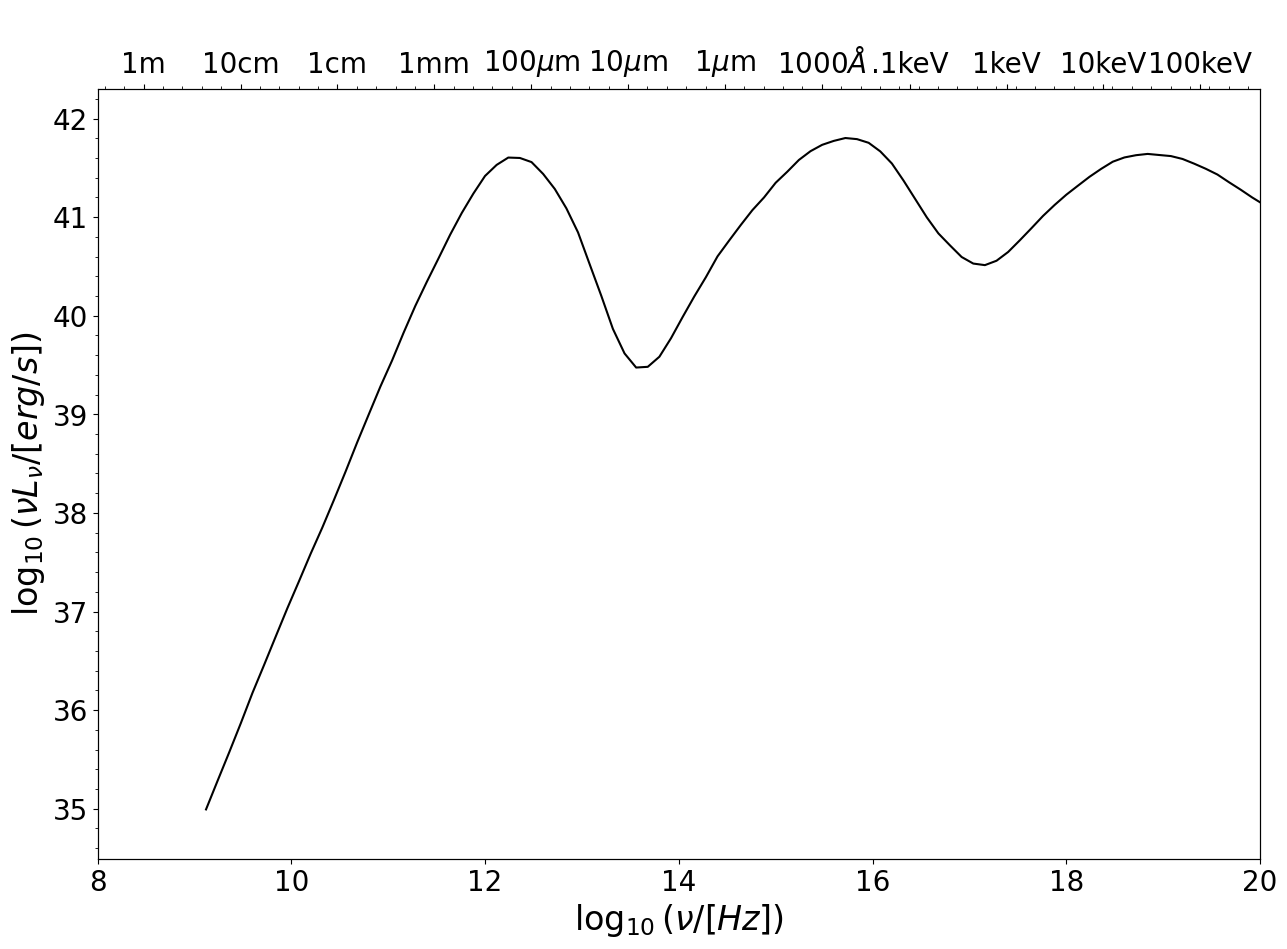

In [14]:
real_mass0=RP.real_mass
logmdotj0=RP.logmdot_jet_max
p0=RP.p_max
epse0=RP.logepse_max
epsb0=RP.logepsb_max
logmdot0=RP.logmdot_max
s0=RP.s_max
delta0=RP.delta_max


x,y=RF.sed_calculator('adaf',real_mass=real_mass0,delta=delta0,mdot=logmdot0,s=s0,
                       mdotj=logmdotj0,p=p0,epse=epse0,epsb=epsb0,plot=True)

## Sandbox

In [13]:
adaf_sed=RM.adaf.predict(np.array([[1e8, 0.3, -3, 0.1]]))[0]*Y_min + Y_max

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


NameError: name 'Y_min' is not defined